In [13]:
import sys
import os
import ctypes
import copy


# Get the absolute path of the utils directory
utils_path = os.path.abspath("../lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *
import random

In [76]:
def read_packing_results(filename):
    result = []
    bounding_width = None  # Initialize bounding width variable

    with open(filename, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            line = line.strip()
            
            # Check if the line contains the bounding width
            if line.startswith("Bounding Width:"):
                bounding_width = int(line.split(":")[1].strip())
                continue  # Skip this line, as we've already processed the bounding width

            # Skip bounding height line
            if line.startswith("Bounding Height:"):
                continue

            # Check if the line contains tile data
            if line.startswith("Preplaced") or line.startswith("Placed"):
                parts = line.split()

                # Extract Position_x and the tile parts
                position_x = int(parts[1])  # Position_x comes after "Preplaced" or "Placed"
                tile_parts = []

                i = 2
                while i < len(parts):
                    w = int(parts[i])
                    h = int(parts[i + 1])
                    dx = int(parts[i + 2])
                    dy = int(parts[i + 3])
                    tile_parts.append((w, h, dx, dy))
                    i += 4

                result.append([position_x, tile_parts])

    return bounding_width, result

def export_separation(filename, separation_value):
    with open(filename, 'w') as f:
        f.write(str(separation_value) + '\n')

In [5]:
def find_inter_module_tiles(tiles_lst, seam_lst):
    inter_tiles = []
    intra_tiles = []
    for cur_tile in tiles_lst:
        inter = False
        w,h,x,y = cur_tile[0]
        for i in range(len(seam_lst)):
            seam = seam_lst[i]
            if y < seam and y+h >= seam:
                inter_tiles.append(cur_tile)
                inter = True
        if not inter:
            intra_tiles.append(cur_tile)
    return inter_tiles, intra_tiles

In [6]:
def expand_inter_tiles(inter_tiles, expand_size):
    expanded_tiles = copy.deepcopy(inter_tiles)
    for i in range(len(expanded_tiles)):
        inter_tile = expanded_tiles[i]
        cur_inter_tile = [[inter_tile[0][0], inter_tile[0][1], inter_tile[0][2], inter_tile[0][3]]]
        cur_inter_tile[0][0] += expand_size
        expanded_tiles[i] = cur_inter_tile
    return expanded_tiles

In [7]:
def shrink_placed_tiles(placed_tiles, shrink_size):
    shrinked_tiles = []
    for placed_tile in placed_tiles:
        x, tile = placed_tile
        new_tile = list(copy.deepcopy(tile[0]))
        new_tile[0] -= shrink_size
        new_tile = tuple(new_tile)
        shrinked_tiles.append((x, [new_tile]))
    return shrinked_tiles

In [8]:
def export_placed_tiles(placed_tiles, output_file):
    # Determine the bounding width (maximum x-coordinate of the placed tiles plus their width)
    bounding_width = max(placed_x + w for placed_x, [(w, h, dx, dy)] in placed_tiles)

    with open(output_file, 'w') as f:
        # Write the bounding width to the file
        f.write(f"Bounding Width: {bounding_width}\n")

        # Write the placed tiles and their single part
        for placed_x, [(w, h, dx, dy)] in placed_tiles:
            f.write(f"{placed_x} {w} {h} {dx} {dy}\n")

    print(f"Placed tiles exported to: {output_file}")

In [ ]:
N = 24; f_orbs = (2,2,2,2,2,2)
seam_lst = [8,16]
prehead = "../../H_12_cluster/"
distance = 3.0
uop, all_g = read_uop(distance, 1.0,prehead)
epsilon_lst1 = np.linspace(3.6,3.9,4)
epsilon_lst = np.linspace(4,5.0,11)
epsilon_lst = np.concatenate([epsilon_lst1[2:4], epsilon_lst])
epsilon_lst = 10**-(epsilon_lst)
epsilon = 0.00012589254117941674
print(epsilon)
excitations = create_excitation(uop, all_g, epsilon)
seam_lst = [8,16]
ratio = 5
excitations = create_excitation(uop, all_g, epsilon)
excitations = orbital_reordering(excitations, f_orbs)
tiles = create_circuit_tile(excitations)

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
0.00012589254117941674


In [10]:
inter_tiles, intra_tiles = find_inter_module_tiles(tiles, seam_lst)
intra_name = "./tiles/intra_tiles.txt"
intra_tiles = sorted(intra_tiles, key=lambda x: sum(h for w, h, _, _ in x), reverse=False)
# tiles = create_circuit_tile(excitations)
export_tiles_to_file(intra_tiles, intra_name)

inter_name = "./tiles/inter_tiles.txt"
inter_tiles = sorted(inter_tiles, key=lambda x: sum(h for w, h, _, _ in x), reverse=False)
# tiles = create_circuit_tile(excitations)
export_tiles_to_file(inter_tiles, inter_name)

Tiles successfully exported to ./tiles/intra_tiles.txt
Tiles successfully exported to ./tiles/inter_tiles.txt


In [ ]:
# random.shuffle(tiles)
tiles = sorted(tiles, key=lambda tile: tile[0][1], reverse=True)
# tiles = create_circuit_tile(excitations)
filename = "./tiles/inter_intra_tiles.txt"
export_inter_intra(tiles, filename, seam_lst)
c_directory = "../lib/double_packing.exe"
ratio = 5
separation = 2*ratio
separation_file = "./tiles/separation.txt"
export_separation(separation_file, separation)
bounding_width, placed_tiles_lst = packing_with_c(inter_tiles,c_directory)

Tiles successfully exported to ./tiles/inter_intra_tiles.txt
Current Directory: c:\Users\24835\Desktop\homework\uiuc\Covey\chem\H-chain\src\double_packing\lib\tile_packing.exe
sorted
Tiles successfully exported to C:/Users/24835/Desktop/homework/uiuc/Covey/chem/H-chain/test_tiles.txt
Bounding width: 5440


1600
[[0, [(6, 15, 0, 0)]], [18, [(6, 15, 0, 0)]], [36, [(6, 15, 0, 0)]], [54, [(6, 15, 0, 0)]], [72, [(6, 15, 0, 0)]], [90, [(6, 15, 0, 0)]], [108, [(6, 15, 0, 0)]], [126, [(6, 15, 0, 0)]], [144, [(6, 15, 0, 8)]], [162, [(6, 15, 0, 8)]], [180, [(6, 15, 0, 8)]], [198, [(6, 15, 0, 8)]], [216, [(6, 15, 0, 8)]], [234, [(6, 15, 0, 8)]], [252, [(6, 15, 0, 8)]], [270, [(6, 15, 0, 8)]], [288, [(6, 13, 0, 0)]], [306, [(6, 13, 0, 0)]], [324, [(6, 13, 0, 0)]], [342, [(6, 13, 0, 0)]], [360, [(6, 13, 0, 0)]], [378, [(6, 13, 0, 0)]], [396, [(6, 13, 0, 0)]], [414, [(6, 13, 0, 0)]], [432, [(6, 13, 0, 2)]], [450, [(6, 13, 0, 2)]], [468, [(6, 13, 0, 2)]], [486, [(6, 13, 0, 2)]], [504, [(6, 13, 0, 2)]], [522, [(6, 13, 0, 2)]], [540, [(6, 13, 0, 2)]], [558, [(6, 13, 0, 2)]], [576, [(6, 13, 0, 8)]], [594, [(6, 13, 0, 8)]], [612, [(6, 13, 0, 8)]], [630, [(6, 13, 0, 8)]], [648, [(6, 13, 0, 8)]], [666, [(6, 13, 0, 8)]], [684, [(6, 13, 0, 8)]], [702, [(6, 13, 0, 8)]], [720, [(6, 13, 0, 10)]], [738, [(6, 13, 0

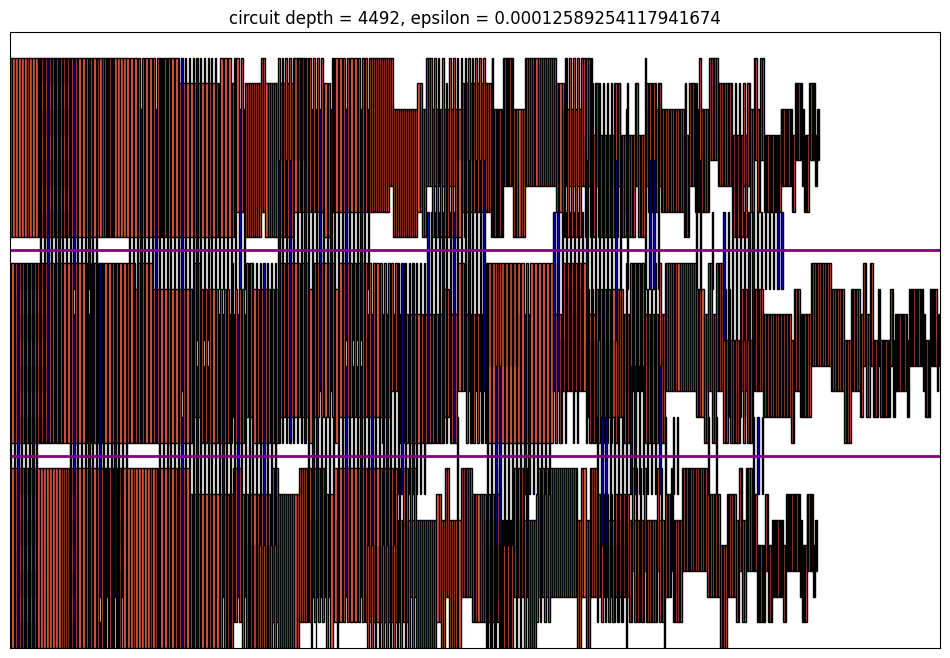

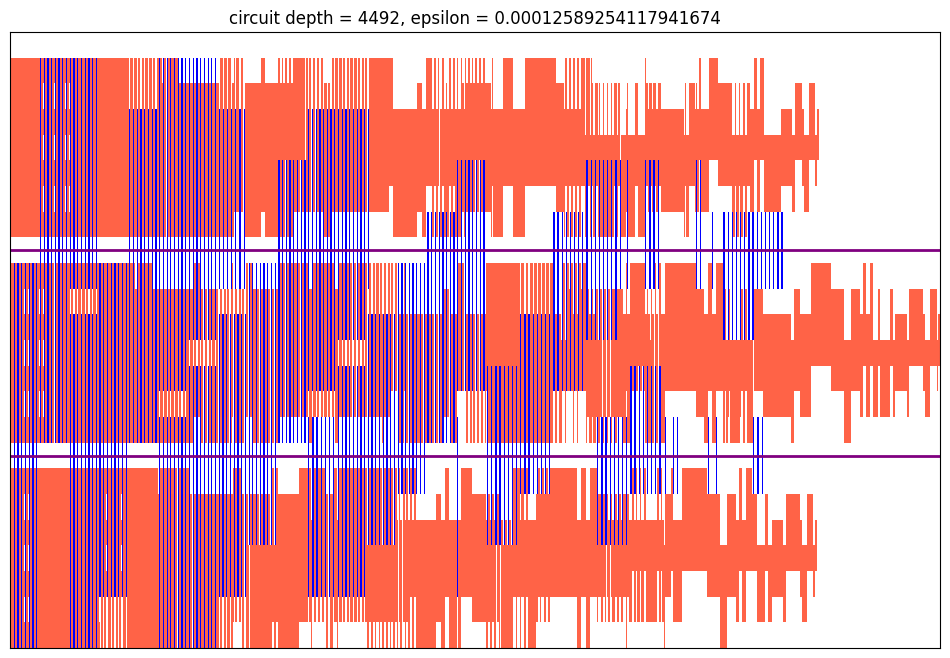

In [89]:
filename = './tiles/result_tiles.txt'
bounding_width, placed_tiles = read_packing_results(filename)
print(len(placed_tiles))
# placed_tiles.extend(moved_placed_tiles)
placed_tiles_lst = placed_tiles
print(placed_tiles)
placed_tiles = TilePacker(placed_tiles, bounding_width, N)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue",edge=True)
placed_tiles.draw_packing([],seam_lst,epsilon,inter_color="blue", edge=False)
